In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [2]:
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

In [3]:
data_all = np.load("/home/yihanhu/workdir/DeepLearningHomeworks/Datasets/PEMS04.npz")
data = data_all["data"][:, 0:30, 0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)  # 归一化
sensordata_num, sensor_num, _ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set.append(torch.tensor(np.array(sliding_window(train_seq,window_size=10)).squeeze(-1)))
    test_set.append(torch.tensor(np.array(sliding_window(test_seq,window_size=10)).squeeze(-1)))
train_set,test_set= torch.stack(train_set, dim=1), torch.stack(test_set, dim=1)
print(train_set.shape, test_set.shape)

torch.Size([13583, 30, 10]) torch.Size([3389, 30, 10])


In [4]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

def denormalize(x):
    return x * (dmax - dmin) + dmin

In [5]:
device = 'cuda:1'
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU())

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.linear(out[:, :, :])
        return hidden, out
        
model = MyGRU(9, 32, 1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
train_log = []
test_log = []
# 开始时间
timestart = time.time()
trained_batches = 0  # 记录多少个batch
for epoch in range(100):

    total_1oss = 0  # 记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        # 每一个batch的开始时间
        batchstart = time.time()

        batch = batch.float().to(device)  # (batch, seq_len)
        x, label = batch[:, :, :9], batch[:, :, 9:10]
        hidden, out = model(x)
        prediction = out[:, :, :]
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trained_batches += 1
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs' % (trained_batches, loss, train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs' % (trained_batches, loss, train_batch_time))

        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            # 每一个batch的开始时间
            batch_test_start = time.time()
            # 在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = batch.float().to(device)
                x, label = batch[:, :, :9], batch[:, :, 9:10]
                hidden, out = model(x)
                prediction = out[:, :, :]
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction).squeeze(-1)
            all_label = test_set[:, :, -1]
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print(
                'test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs' % (
                trained_batches, rmse_score, mae_score, mape_score, test_batch_time))
            print(
                'test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs' % (
                trained_batches, rmse_score, mae_score, mape_score, test_batch_time))

batch 1, train_loss 0.038686,Time used 0.425265s
batch 1, train_loss 0.038686,Time used 0.425265s
batch 2, train_loss 0.040532,Time used 0.026599s
batch 2, train_loss 0.040532,Time used 0.026599s
batch 3, train_loss 0.040370,Time used 0.021614s
batch 3, train_loss 0.040370,Time used 0.021614s
batch 4, train_loss 0.037970,Time used 0.021791s
batch 4, train_loss 0.037970,Time used 0.021791s
batch 5, train_loss 0.036039,Time used 0.025674s
batch 5, train_loss 0.036039,Time used 0.025674s
batch 6, train_loss 0.036892,Time used 0.027831s
batch 6, train_loss 0.036892,Time used 0.027831s
batch 7, train_loss 0.034545,Time used 0.022035s
batch 7, train_loss 0.034545,Time used 0.022035s
batch 8, train_loss 0.032582,Time used 0.022500s
batch 8, train_loss 0.032582,Time used 0.022500s
batch 9, train_loss 0.031526,Time used 0.017818s
batch 9, train_loss 0.031526,Time used 0.017818s
batch 10, train_loss 0.034361,Time used 0.030272s
batch 10, train_loss 0.034361,Time used 0.030272s
batch 11, train_lo

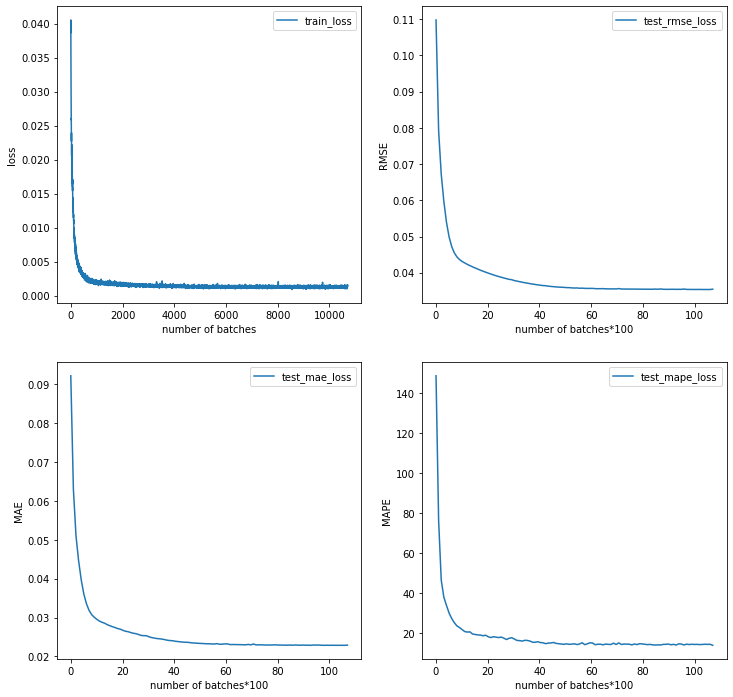

In [7]:
#train_loss曲线
plt.figure(1, figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

plt.sca(ax1)
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()


#test_loss曲线-MSE
plt.sca(ax2)
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("RMSE")
plt.legend()

#test_loss曲线-RMSE
plt.sca(ax3)
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("MAE")
plt.legend()



#test_loss曲线-MAPE
plt.sca(ax4)
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("MAPE")
plt.legend()
plt.show()